In [225]:
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient

# Load values from the .env file
load_dotenv()

# Get values from the environment variables
qdrant_url = os.getenv("QDRANT_URL")
qdrant_api_key = os.getenv("QDRANT_API_KEY")

# Create the QdrantClient instance
qdrant_client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key,
)


/home/skeptrune/.local/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:115: UserWarning: Api key is used with unsecure connection.
  warnings.warn("Api key is used with unsecure connection.")


In [196]:
import clickhouse_connect

clickhouse_client = clickhouse_connect.get_client()
clickhouse_client.server_version

'23.3.9.55'

In [149]:
create_table_query = """
CREATE TABLE IF NOT EXISTS qdrant_point_ids
(
    `point_id` String,
    `embedding_vector` Array(Float32),
)
ENGINE = MergeTree
ORDER BY point_id
"""

clickhouse_client.query(create_table_query)

offset = ""

while offset is not None:
    scroll_result = qdrant_client.scroll(
        collection_name="debate_cards",
        limit=100,
        with_vectors=True,
        offset=(offset if offset else None),
    )

    offset = scroll_result[1]

    insert_found_points_query = """
        INSERT INTO qdrant_point_ids
        VALUES
        """
    
    for point in scroll_result[0]:
        insert_found_points_query += f"('{point.id}', {point.vector}),"

    clickhouse_client.query(insert_found_points_query)

In [152]:
import time


base_count = 0
while base_count != 255070:
    get_qdrant_point_ids_count_query = """
    SELECT COUNT(*)
    FROM qdrant_point_ids
    """
    base_count = clickhouse_client.query(get_qdrant_point_ids_count_query).result_rows[0][0]

    time.sleep(1)


ch_tables = [1, 10, 100, 1000, 10000]

allow_experimental_indexes_query = """
SET allow_experimental_annoy_index = 1
"""

clickhouse_client.query(allow_experimental_indexes_query)

for ch_table in ch_tables:
    drop_table_query = f"""
    DROP TABLE IF EXISTS qdrant_benchmark_{ch_table}
    """
    clickhouse_client.query(drop_table_query)

    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS qdrant_benchmark_{ch_table} (
        `point_id` String,
        `embedding_vector` Array(Float32),
        INDEX annoy_embedding_vector embedding_vector TYPE annoy(100, 'cosineDistance') GRANULARITY {ch_table},
    )
    ENGINE = MergeTree()
    ORDER BY point_id
    """
    clickhouse_client.query(create_table_query)

    insert_points_query = f"""
    INSERT INTO qdrant_benchmark_{ch_table}
    SELECT * FROM qdrant_point_ids
    """

    clickhouse_client.query(insert_points_query)

In [153]:
for ch_table in ch_tables:
    temp_count = 0
    while temp_count != base_count:
        get_qdrant_point_ids_count_query = f"""
        SELECT COUNT(*)
        FROM qdrant_benchmark_{ch_table}
        """
        temp_count = clickhouse_client.query(get_qdrant_point_ids_count_query).result_rows[0][0]

        time.sleep(1)

In [161]:
scroll_result = qdrant_client.scroll(
    collection_name="debate_cards",
    limit=100,
    with_vectors=True,
)

first_100_qdrant_vectors = [point.vector for point in scroll_result[0]]

In [157]:
import numpy as np
import timeit

qdrant_search_times = []
ch_qdrant_point_ids_search_times = []
ch_benchmark_search_times = {}
for ch_table in ch_tables:
    ch_benchmark_search_times[ch_table] = []


for i in range(100):
    query_vector = np.random.rand(1536).astype(np.float32).tolist()

    for ch_table in ch_tables:
        ch_mid_cosine_similarity_query = f"""
        SELECT
            point_id,
            cosineDistance(embedding_vector, {query_vector}) AS score
        FROM qdrant_benchmark_{ch_table}
        ORDER BY score ASC
        LIMIT 10
        """

        ch_benchmark_search_times[ch_table].append(timeit.timeit(lambda: clickhouse_client.query(ch_mid_cosine_similarity_query), number=1))

    ch_qdrant_point_id_query = f"""
    SELECT
        point_id,
        cosineDistance(embedding_vector, {query_vector}) AS score
    FROM qdrant_point_ids
    ORDER BY score ASC
    LIMIT 10
    """
    ch_qdrant_point_ids_search_times.append(timeit.timeit(lambda: clickhouse_client.query(ch_qdrant_point_id_query), number=1))

    qdrant_search_times.append(timeit.timeit(lambda: qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, search_params={"exact": True}), number=1))

    

In [158]:
import subprocess
import re

def calculate_avg_latency(ip_address, count=5):
    try:
        ping_output = subprocess.check_output(["ping", "-c", str(count), ip_address]).decode("utf-8")
        latency_values = re.findall(r"time=(\d+\.\d+)", ping_output)
        
        if latency_values:
            latencies = [float(value) for value in latency_values]
            avg_latency = sum(latencies) / len(latencies)
            return avg_latency
        else:
            return None
    except subprocess.CalledProcessError:
        return None

target_ip = "5.78.80.122"
count = 5

average_latency = calculate_avg_latency(target_ip, count)

average_latency_in_seconds = average_latency / 1000

qdrant_search_times = [time - average_latency_in_seconds for time in qdrant_search_times]

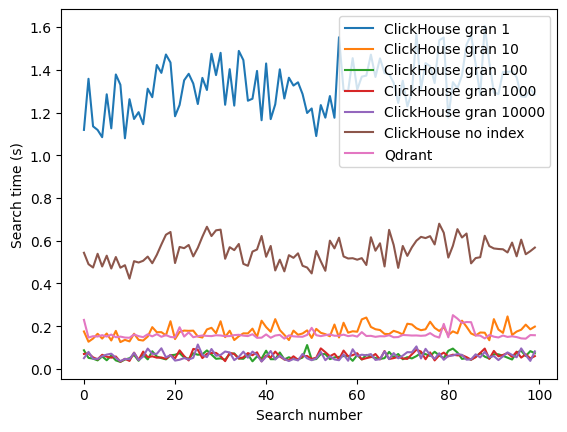

In [227]:
# plot the results

import matplotlib.pyplot as plt

for ch_table in ch_tables:
    plt.plot(ch_benchmark_search_times[ch_table], label=f"ClickHouse gran {ch_table}")

plt.plot(ch_qdrant_point_ids_search_times, label="ClickHouse no index")
plt.plot(qdrant_search_times, label="Qdrant")

plt.xlabel("Search number")
plt.ylabel("Search time (s)")
plt.legend()
plt.show()

In [162]:
# Get avg, max, min search time for ClickHouse
[ch_avg_search_time, ch_max_search_time, ch_min_search_time] = [np.mean(ch_qdrant_point_ids_search_times), np.max(ch_qdrant_point_ids_search_times), np.min(ch_qdrant_point_ids_search_times)]
# Get avg, max, min search time for Qdrant
[qdrant_avg_search_time, qdrant_max_search_time, qdrant_min_search_time] = [np.mean(qdrant_search_times), np.max(qdrant_search_times), np.min(qdrant_search_times)]

# Display the results
print(f"ClickHouse no index avg search time: {ch_avg_search_time}s")
print(f"ClickHouse no index max search time: {ch_max_search_time}s")
print(f"ClickHouse no index min search time: {ch_min_search_time}s")

print(f"Qdrant avg search time: {qdrant_avg_search_time}s")
print(f"Qdrant max search time: {qdrant_max_search_time}s")
print(f"Qdrant min search time: {qdrant_min_search_time}s")

for ch_table in ch_tables:
    print(f"ClickHouse {ch_table} avg search time: {np.mean(ch_benchmark_search_times[ch_table])}s")
    print(f"ClickHouse {ch_table} max search time: {np.max(ch_benchmark_search_times[ch_table])}s")
    print(f"ClickHouse {ch_table} min search time: {np.min(ch_benchmark_search_times[ch_table])}s")

ClickHouse no index avg search time: 0.5497443559493695s
ClickHouse no index max search time: 0.6795598349999636s
ClickHouse no index min search time: 0.4224137220007833s
Qdrant avg search time: 0.1595812933897157s
Qdrant max search time: 0.251358743999959s
Qdrant min search time: 0.14133246699486862s
ClickHouse 1 avg search time: 1.3250578371307347s
ClickHouse 1 max search time: 1.605351481004618s
ClickHouse 1 min search time: 1.0793820499966387s
ClickHouse 10 avg search time: 0.17490683227952103s
ClickHouse 10 max search time: 0.24544750800123438s
ClickHouse 10 min search time: 0.12525474799622316s
ClickHouse 100 avg search time: 0.05880631781124976s
ClickHouse 100 max search time: 0.11143850900407415s
ClickHouse 100 min search time: 0.032431642001029104s
ClickHouse 1000 avg search time: 0.06087649374938337s
ClickHouse 1000 max search time: 0.09586849999323022s
ClickHouse 1000 min search time: 0.033497715994599275s
ClickHouse 10000 avg search time: 0.06079291757007013s
ClickHouse 100

In [214]:
no_index_results = []
qdrant_results = []
ch_benchmark_results = {}
for ch_table in ch_tables:
    ch_benchmark_results[ch_table] = []

for i in range(100):
    query_vector = first_100_qdrant_vectors[i]

    ch_no_index_query = f"""
    SELECT
        point_id,
        cosineDistance(embedding_vector, {query_vector}) AS score
    FROM qdrant_point_ids
    ORDER BY score ASC
    LIMIT 10
    """

    ch_no_index_temp = clickhouse_client.query(ch_no_index_query).result_rows
    ch_no_index_ids = [result[0] for result in ch_no_index_temp]
    no_index_results += ch_no_index_ids

    qdrant_results_temp = qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, with_vectors=False, search_params={"exact": True})
    qdrant_ids = [result.id for result in qdrant_results_temp]
    qdrant_results += qdrant_ids

    base_ids = []

    for ch_table in ch_tables:
        ch_benchmark_query = f"""
        SELECT
            point_id,
            cosineDistance(embedding_vector, {query_vector}) AS score
        FROM qdrant_benchmark_{ch_table}
        ORDER BY score ASC
        LIMIT 10
        """

        ch_index_temp = clickhouse_client.query(ch_benchmark_query)
        ch_index_ids = [result[0] for result in ch_index_temp.result_rows]
        ch_benchmark_results[ch_table] += ch_index_ids

In [230]:
if no_index_results == qdrant_results:
    print("No index and Qdrant results are the same")

qdrant_diffs = {}
no_index_diffs = {}

for ch_table in ch_tables:
    qdrant_diffs[ch_table] = 0
    no_index_diffs[ch_table] = 0

for idx in range(len(ch_benchmark_results[ch_table])):
    for ch_table in ch_tables:
        if ch_benchmark_results[ch_table][idx] != qdrant_results[idx]:
            qdrant_diffs[ch_table] += 1
        if ch_benchmark_results[ch_table][idx] != no_index_results[idx]:
            no_index_diffs[ch_table] += 1


print("qdrant to indexed", qdrant_diffs)
print("no index to indexed", no_index_diffs)

No index and Qdrant results are the same
qdrant to indexed {1: 0, 10: 890, 100: 897, 1000: 897, 10000: 897}
no index to indexed {1: 0, 10: 890, 100: 897, 1000: 897, 10000: 897}
